In [1]:
!pip install pandas 
!pip install seaborn
!pip install keras_tuner --upgrade
!pip install scikit-learn
#!pip install google.colab


     |████████████████████████████████| 12.2 MB 5.3 MB/s 
     |████████████████████████████████| 499 kB 18.6 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 293 kB 6.0 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 169 kB 6.0 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.8 MB 6.9 MB/s 
     |████████████████████████████████| 34.5 MB 365 kB/s 
     |████████████████████████████████| 297 kB 21.2 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt 
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as  pd
import io
from PIL import Image, ImageFilter
import pandas as pd
import numpy as np
#from google.colab import files


# New Section

In [3]:
#Taking input of cloud excel file 

#uploaded = files.upload()

#df = pd.read_csv(io.BytesIO(uploaded['clouds_train_small.csv']))
df = pd.read_csv('clouds_train.csv')
print(df)

      Unnamed:0      Cloud File      R-Mean      G-Mean      B-Mean  \
0             0  1546354560.jpg  146.787763  141.553899  142.096140   
1             1  1546440960.jpg  147.739283  141.985004  141.911820   
2             2  1546527360.jpg  110.025239  129.619532  152.580028   
3             3  1546613760.jpg  251.806996  246.919345  254.796573   
4             4  1546700160.jpg  109.728115  123.708050  138.251081   
...         ...             ...         ...         ...         ...   
5150       5150  1574445360.jpg         NaN         NaN         NaN   
5151       5151  1574531760.jpg         NaN         NaN         NaN   
5152       5152  1574618160.jpg         NaN         NaN         NaN   
5153       5153  1574704560.jpg         NaN         NaN         NaN   
5154       5154  1574790960.jpg         NaN         NaN         NaN   

           R-Var       G-Var       B-Var  Edge-DetectionValue  Label  
0     240.999194  153.610553  164.936167             1.125122      3  
1    

In [4]:
def loadWeatherFile(filename, image_width = -1):
  import urllib.request
  import io
  from PIL import Image
  url = "http://uindy-weathercam.s3.us-east-2.amazonaws.com/" + filename
  fh = urllib.request.urlopen(url)
  if image_width == -1:
    return Image.open(io.BytesIO(fh.read()))
  else:
    im = Image.open(io.BytesIO(fh.read()))
    width, height = im.size
    image_height = image_width / width * height
    im = im.resize( (int(image_width), int(image_height)), Image.ANTIALIAS)
    return im

#Loading the file .jpg name then the labels 
df = df[['Cloud File', 'Label']]
df = df.astype({'Label': 'int32'}) # 
#if the label is 3 (rain picture) or 5 (bad picture) they're not accepted 
df = df.loc[(df.Label != 5) & (df.Label != 3)].reset_index(drop=True)
df.loc[df.Label == 4, 'Label'] = 3

df = df.sample(frac=1, random_state=2).reset_index(drop=True)

# cloud_train = df.sample(frac=0.8, random_state = 0)
# cloud_test = df.drop(cloud_train.index)

print(df)
print(df.dtypes)

          Cloud File  Label
0     1570452960.jpg      1
1     1568924760.jpg      2
2     1571838960.jpg      3
3     1586530560.jpg      2
4     1594742160.jpg      2
...              ...    ...
4514  1536850560.jpg      0
4515  1566143760.jpg      1
4516  1582923360.jpg      1
4517  1537026960.jpg      3
4518  1589316960.jpg      2

[4519 rows x 2 columns]
Cloud File    object
Label          int32
dtype: object


<ipython-input-4-5e52092666f6>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize( (int(image_width), int(image_height)), Image.ANTIALIAS)
<ipython-input-4-5e52092666f6>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize( (int(image_width), int(image_height)), Image.ANTIALIAS)
<ipython-input-4-5e52092666f6>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize( (int(image_width), int(image_height)), Image.ANTIALIAS)
<ipython-input-4-5e52092666f6>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize( (int(image_width), int(image_height)), Image.ANTIALIAS)
<ipython-input-4-5e52092666f6>:13: DeprecationWarning: ANTIALIAS is depr

Done processing images
(4519, 112, 200, 3)
(4519,)


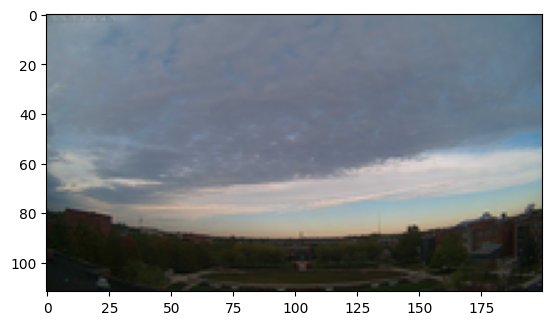

In [5]:
from multiprocessing import Pool, TimeoutError 

#load all ofthe files from the bucket, calling the above function
def f(filename):
    arr = np.array(loadWeatherFile(filename,200))  # <<---------- Image width! Can play with this to resize images for less CPU/GPU power 
    #making all the pixels from 0-1
    arr = arr / 255.0
    return arr

image_filenames = df[:]['Cloud File'].tolist()
with Pool(processes=12) as pool:      
    image_arr = pool.map(f, image_filenames)
print("Done processing images")
    
#making the np array of the 2D images 
image_feature = np.asarray(image_arr)
print(image_feature.shape)

#loading the labels so they're with the correct image 
image_labels = df[:(image_feature.shape[0])]['Label']
print(image_labels.shape)

#showing the first image in the array 
plt.imshow(image_feature[0])
plt.show()

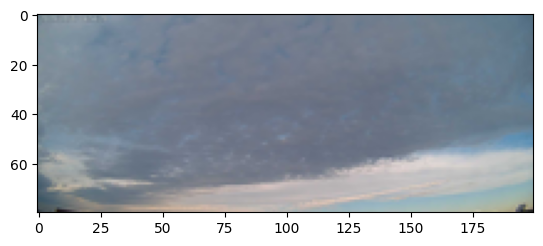

In [6]:
image_cropped = []

#to minimize computing power, taking out the ground of all images 
for i in range(len(image_feature)):
                                    #might need to change this dependent on the size of the image 
 image_cropped.append(image_feature[i][0:80,:])


plt.imshow(image_cropped[0])
plt.show()

#putting back the images to the normal features list 
image_features = np.asarray(image_cropped)

In [7]:
#current shape of the array 
#(number of images, height, length, pixel colours)
print(image_features.shape)


(4519, 80, 200, 3)


In [8]:
#creating a new list of horizontally flipped images
horflip = np.flip(image_features, axis = 2)
#copying the labels over so can still  be correct 
horlab = image_labels.copy()

#concatenating the two above lists back into original, doubling the number of images 
image_features = (np.concatenate((image_features, horflip),axis = 0))
image_labels = np.concatenate((image_labels, horlab))

In [9]:
#check to make sure the number has doubled 
print(image_features.shape)

(9038, 80, 200, 3)


In [10]:
cropped_images_left = []
cropped_images_right = []
img_lab = image_labels.copy()

for i in range(len(image_features)):
  image = image_features[i]
  #image_features = np.append(image[0:120, 0:300], axis = 0)
  cropped_images_left.append(image[0:200, 0:100])
  cropped_images_right.append(image[0:200, 100:200])

print(len(cropped_images_left))
print(len(cropped_images_right))

cut_switched = []

for i in range(len(image_features)):
  temp = np.concatenate((cropped_images_right[i],cropped_images_left[i]), axis = 1)
  cut_switched.append(temp)
  # plt.imshow(temp)
  # plt.show()

image_features = (np.concatenate((image_features, cut_switched), axis = 0))
image_labels = np.concatenate((image_labels, img_lab))

print(image_features.shape)
print(image_labels.shape)

9038
9038
(18076, 80, 200, 3)
(18076,)


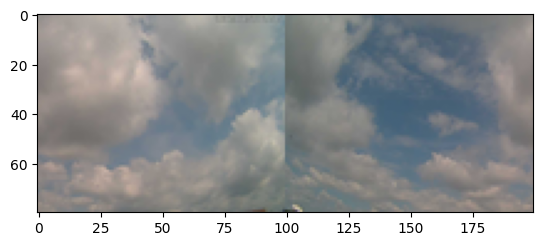

Cumulus


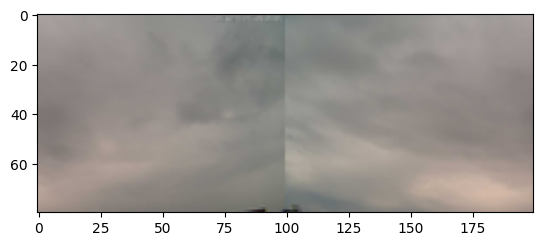

Stratus


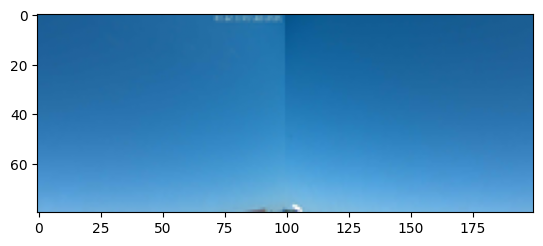

No Clouds


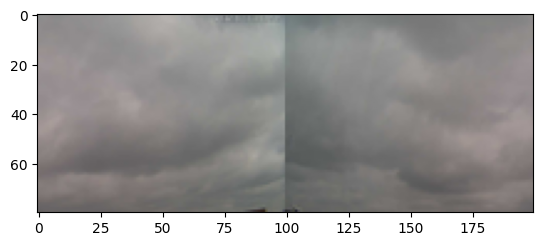

Stratus


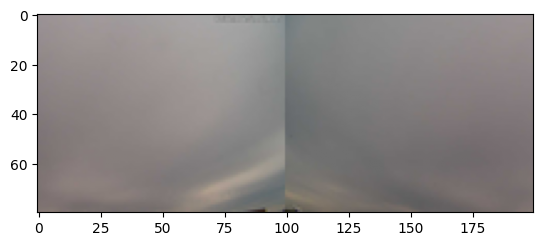

Stratus


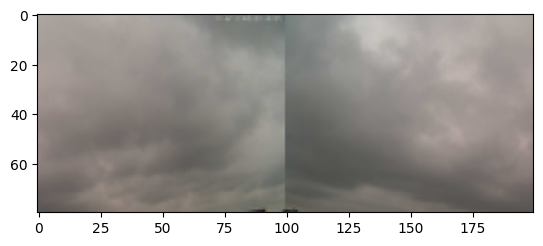

Stratus


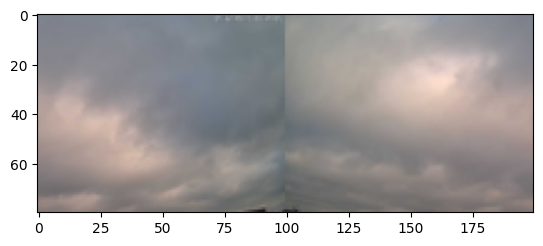

Stratus


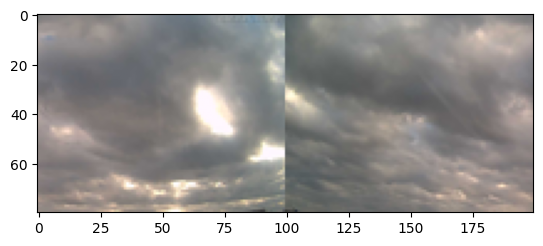

Stratus


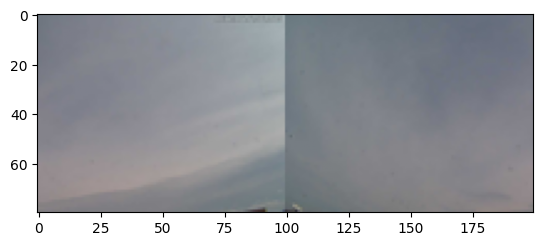

Stratus


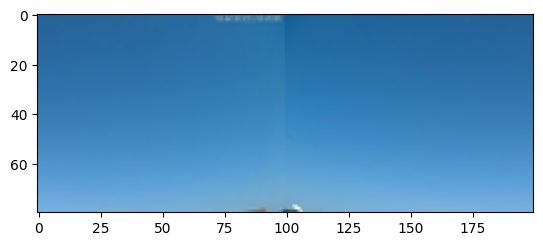

No Clouds


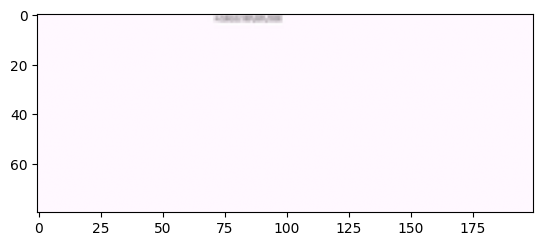

Cirrus


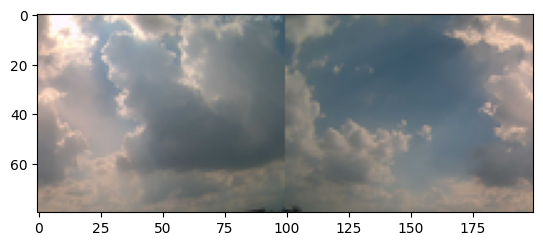

Cumulus


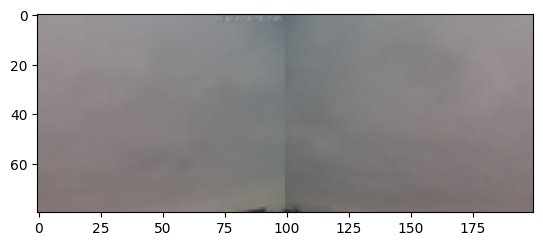

Stratus


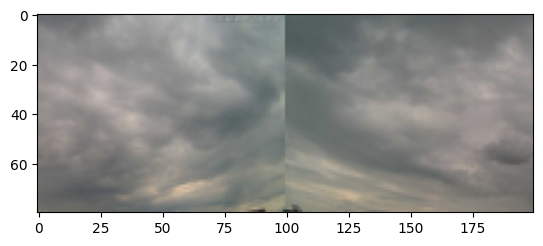

Stratus


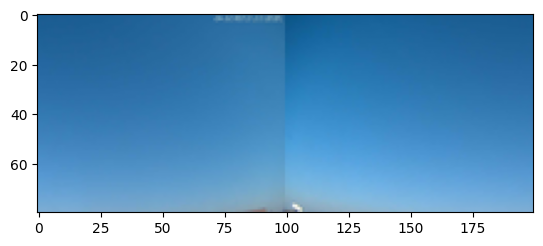

No Clouds


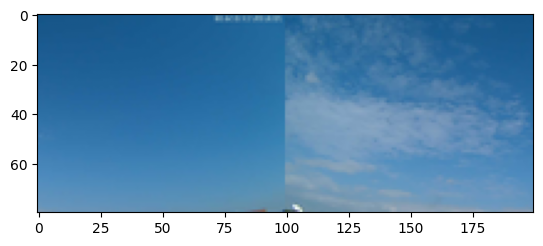

Cirrus


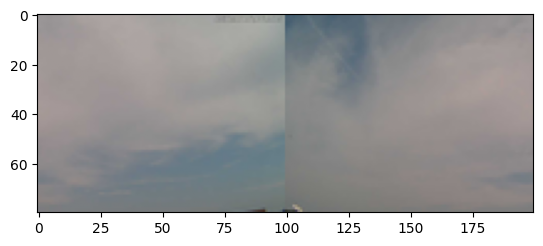

Stratus


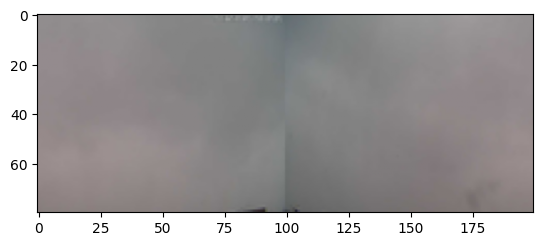

Stratus


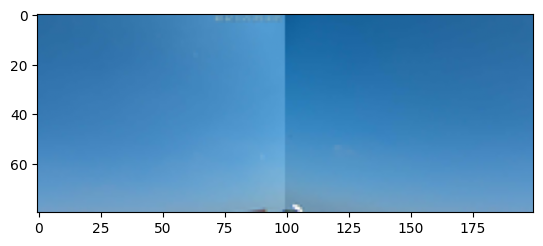

No Clouds


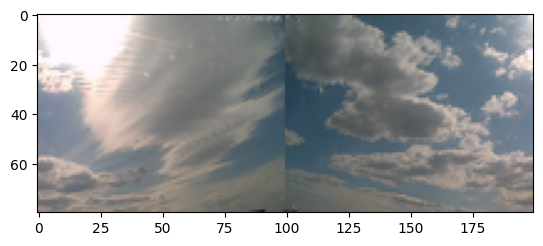

Cumulus


<bound method NDFrame.describe of 0       1
1       2
2       3
3       2
4       2
       ..
4514    0
4515    1
4516    1
4517    3
4518    2
Name: Label, Length: 4519, dtype: int32>

In [11]:
labels = ['Cirrus','Stratus','Cumulus', 'No Clouds']  # Change me!


for i in range(len(image_features)-20, len(image_features)):
    plt.imshow(image_features[i])
    plt.show()
    print(labels[image_labels[i]])
df[:]['Label'].describe

In [12]:
print(image_features.shape)


(18076, 80, 200, 3)


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(image_features, image_labels, test_size = 0.20, random_state=1)

In [15]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(14460, 80, 200, 3)
(14460,)
(3616, 80, 200, 3)
(3616,)


In [16]:
model = None 


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, activation='relu',
                               padding='same'),
    tf.keras.layers.AvgPool2D(pool_size=2, strides=3),
    tf.keras.layers.Conv2D(filters=4, kernel_size=5,
                               activation='relu'),
    tf.keras.layers.AvgPool2D(pool_size=2, strides=3),
    tf.keras.layers.Conv2D(filters=4, kernel_size=5,
                               activation='relu'),
    tf.keras.layers.AvgPool2D(pool_size=2, strides=3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu' ),
    tf.keras.layers.Dense(128, activation='relu' ),
    tf.keras.layers.Dense(480, activation='relu' ),
    tf.keras.layers.Dense(128, activation='relu' ),
    tf.keras.layers.Dense(480, activation='relu' ),
    tf.keras.layers.Dense(units=4),#, kernel_initializer=init)
])

In [17]:
print(image_features.shape)

(18076, 80, 200, 3)


In [18]:
# Attemp to predict something - this will allow the model to know the input shape for the summary later!
model.predict(X_train) 

model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)) 
print(model.summary())
history = None


452/452 [==============================] - 3s 4ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 200, 4)        304       
                                                                 
 average_pooling2d (AverageP  (None, 27, 67, 4)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 63, 4)         404       
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 21, 4)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 17, 4)          404       
                                                                 
 

In [19]:
# train!!!

# Validation and test set discussion: https://machinelearningmastery.com/difference-test-validation-datasets/

#%%time
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.1,
    )

Epoch 1/20
407/407 [==============================] - 6s 9ms/step - loss: 0.9826 - accuracy: 0.5813 - val_loss: 0.8652 - val_accuracy: 0.6390
Epoch 2/20
407/407 [==============================] - 3s 8ms/step - loss: 0.8382 - accuracy: 0.6627 - val_loss: 0.7655 - val_accuracy: 0.6916
Epoch 3/20
407/407 [==============================] - 3s 8ms/step - loss: 0.7468 - accuracy: 0.6999 - val_loss: 0.7333 - val_accuracy: 0.7178
Epoch 4/20
407/407 [==============================] - 3s 8ms/step - loss: 0.7051 - accuracy: 0.7208 - val_loss: 0.6764 - val_accuracy: 0.7483
Epoch 5/20
407/407 [==============================] - 3s 8ms/step - loss: 0.6841 - accuracy: 0.7356 - val_loss: 0.7152 - val_accuracy: 0.7172
Epoch 6/20
407/407 [==============================] - 3s 8ms/step - loss: 0.6661 - accuracy: 0.7427 - val_loss: 0.6704 - val_accuracy: 0.7386
Epoch 7/20
407/407 [==============================] - 3s 8ms/step - loss: 0.6495 - accuracy: 0.7471 - val_loss: 0.6672 - val_accuracy: 0.7400
Epoch 

In [20]:
def evaluate_model(model, X_test, y_test):
   
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

# Evaluate model on test set and add results to dataframe
results = evaluate_model(model, X_test, y_test)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

113/113 [==============================] - 1s 4ms/step - loss: 0.6254 - accuracy: 0.7602


,loss,accuracy
Baseline,0.625381,0.760232


In [21]:
def build_model(hp):
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    #------Might have to add the input_shape=() into
    model.add(keras.layers.Flatten())
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=1024, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [22]:

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                    #  directory="CloudID",
                    #  project_name="CloudID_Optimizer",
                     )

In [23]:
#
#Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [24]:
# #stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=2)


Trial 267 Complete [00h 00m 59s]
val_accuracy: 0.5404564142227173

Best val_accuracy So Far: 0.6445366740226746
Total elapsed time: 02h 29m 29s

Search: Running Trial #268

Value             |Best Value So Far |Hyperparameter
6                 |3                 |num_layers
800               |928               |units_1
0.2               |0.1               |dropout_1
0.0001            |0.0001            |learning_rate
128               |256               |units_2
0.1               |0.1               |dropout_2
864               |128               |units_3
0.2               |0                 |dropout_3
288               |736               |units_4
0.1               |0.1               |dropout_4
256               |384               |units_5
0.2               |0.1               |dropout_5
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tune

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 250, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 215, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/tuners/hyperband.py", line 404, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 286, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/hypermodel.py", line 144, 

ResourceExhaustedError: ignored

In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
h_model.fit(X_train, y_train, epochs=60, validation_split=0.2, verbose=2)


In [ ]:
# Evaluate model on test set
hyper_df = evaluate_model(h_model, X_test, y_test)

# Set index to hypertuned
hyper_df.index = ["Hypertuned"]

# Append results in dataframe
results.append(hyper_df)

In [ ]:
tuner.results_summary()

In [ ]:
# model2 = None 


# model2 = tf.keras.models.rmsprop([
#     tf.keras.layers.Conv2D(filters=4, kernel_size=5, activation='relu',
#                                padding='same'),
#     tf.keras.layers.AvgPool2D(pool_size=2, strides=3),
#     tf.keras.layers.Conv2D(filters=4, kernel_size=5,
#                                activation='relu'),
#     tf.keras.layers.AvgPool2D(pool_size=2, strides=3),
#     tf.keras.layers.Conv2D(filters=4, kernel_size=5,
#                                activation='relu'),
#     tf.keras.layers.AvgPool2D(pool_size=2, strides=3),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu' ),
#     tf.keras.layers.Dense(128, activation='relu' ),
#     tf.keras.layers.Dense(units=4),#, kernel_initializer=init)
# ])

In [ ]:
# # Attemp to predict something - this will allow the model to know the input shape for the summary later!
# model2.predict(X_train) 

# model2.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.0001),
#     metrics=['accuracy'],
#     loss = "sparse_categorical_crossentropy")
#     #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)) 
# print(model2.summary())
# history = None

In [ ]:
# # train!!!

# # Validation and test set discussion: https://machinelearningmastery.com/difference-test-validation-datasets/

# #%%time
# history2 = model2.fit(
#     X_train,
#     y_train,
#     epochs=20,
#     # Suppress logging.
#     verbose=1,
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.1,
#     )

In [ ]:
print(X_train.shape)

In [ ]:
# # Define hypermodel with input shape and number of classes
# hypermodel = kt.applications.HyperResNet(input_shape=(80, 200, 3), classes=4)

# # Instantiate tuner with bayesian optimzation search algorithm and our hypermodel
# tuner = kt.tuners.BayesianOptimization(
#     hypermodel,
#     objective='val_accuracy',
#     max_trials=3,
#     directory="resnet",
#     project_name="para_resnet"
#     )

In [ ]:
# # # ResNet expects shape of convolutional layer
# X_train_res = X_train.reshape(len(X_train), 80, 200, 3)
# X_test_res = X_test.reshape(len(X_test), 80, 200, 3)

# # ResNet expects one-hot encoded labels
# y_train_res = keras.utils.to_categorical(y_train)
# y_test_res = keras.utils.to_categorical(y_test)



In [ ]:
# tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=2)

In [ ]:
# # Get the optimal hyperparameters from the results
# best_hps=tuner.get_best_hyperparameters()[0]

# resnet_model = tuner.hypermodel.build(best_hps)

# # Train the hypertuned model
# resnet_model.fit(X_train_res, y_train_res, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early], verbose=2)


In [ ]:
# tuner.results_summary()

In [ ]:

# resnet_df = evaluate_model(resnet_model, X_test_res, y_test_res)

# resnet_df.index = ["HyperResNet"]

# results.append(resnet_df)